In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import re
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

print("==================================================")
print("   FOOTBALL PREDICTOR (PLAYER STATS + DRAW FIX)   ")
print("==================================================")

# ==========================================
# 1. LOAD & CLEAN
# ==========================================
try:
    df = pd.read_csv("match_data.csv")
except FileNotFoundError:
    print("Error: match_data.csv not found.")
    exit()

def extract_date(url):
    try:
        match = re.search(r'([A-Za-z]+-\d{1,2}-\d{4})', str(url))
        if match: return pd.to_datetime(match.group(1), format='%B-%d-%Y', errors='coerce')
    except: pass
    return pd.NaT

df['date'] = df['match_url'].apply(extract_date)
df = df.sort_values(by='date').reset_index(drop=True)

# --- CLEANING: Basic Stats + NEW PLAYER STATS ---
# Define ALL numeric columns we expect
# basic_stats = ["xg", "possession", "shots_onTarget", "corners", "fouls", "team_points", "team_score", "passing_onTarget", "total_passing", "total_shots", "total_saves", "team_cards_number", "crosses", "touches", "tackels", "interceptions", "aerials", "clearances", "offsides", "goal_kicks", "throw_ins", "long_balls"]

# # New Player Stats (Generic Names)
# player_stats = ["players_npxG", "players_xAG", "players_SCA", "players_GCA", "players_proggresive_passes", "players_carries", "players_proggresive_carries", "players_take_ons_attempted", "players_take_ons_successfull"]

# all_stats = basic_stats + player_stats
def clean_df(df):
    non_numeric_col = ['match_url','home_team_name'	,'away_team_name','xg_is_estimated','date']
    all_stats = [col for col in df.columns if col not in non_numeric_col]
    new_stats = []
    for stat in all_stats:
        if stat.startswith("home_"):
            stat= stat.removeprefix("home_")
        elif stat.startswith("away_"):
            stat = stat.removeprefix("away_")
        new_stats.append(stat)
    new_stats = list(set(new_stats))
    return new_stats

all_stats = clean_df(df)

for side in ['home', 'away']:
    # Possession fix
    p_col = f"{side}_team_possession"
    if p_col in df.columns:
        df[p_col] = pd.to_numeric(df[p_col].astype(str).str.rstrip('%'), errors='coerce').fillna(50) / 100.0
    
    # Generic Cleaning Loop
    for s in all_stats:
        # Determine column name (handle inconsistent naming)
        if s in ["xg", "possession", "team_points", "team_score"]:
            col = f"{side}_team_{s}"
        else:
            col = f"{side}_{s}"
            
        if col in df.columns:
            # Force numeric (coerce errors to NaN)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Impute with Median
            df[col] = df[col].fillna(df.groupby(f'{side}_team_name')[col].transform('median'))
            # Fallback for new teams
            df[col] = df[col].fillna(df[col].mean())
            # Final safety net for empty columns
            df[col] = df[col].fillna(0)

# ==========================================
# 2. FEATURE ENGINEERING
# ==========================================

# --- ELO (Standard +60) ---
def calculate_elo(df):
    k_factor = 20
    home_advantage = 60
    team_elos = {team: 1500 for team in set(df['home_team_name']).union(set(df['away_team_name']))}
    elo_h, elo_a = [], []
    
    for _, row in df.iterrows():
        h, a = row['home_team_name'], row['away_team_name']
        rh, ra = team_elos[h], team_elos[a]
        elo_h.append(rh); elo_a.append(ra)
        
        if row['home_team_score'] > row['away_team_score']: res = 1
        elif row['home_team_score'] == row['away_team_score']: res = 0.5
        else: res = 0
        
        dr = (rh + home_advantage) - ra
        e_h = 1 / (1 + 10 ** (-dr / 400))
        change = k_factor * (res - e_h)
        team_elos[h] = rh + change
        team_elos[a] = ra - change
        
    return elo_h, elo_a, team_elos

df['home_elo'], df['away_elo'], current_elos = calculate_elo(df)
df['diff_elo'] = (df['home_elo'] + 60) - df['away_elo']

# --- Rest Days ---
long_df = pd.concat([
    df[['date', 'home_team_name']].rename(columns={'home_team_name':'team'}),
    df[['date', 'away_team_name']].rename(columns={'away_team_name':'team'})
]).sort_values(['team', 'date'])
long_df['rest'] = (long_df['date'] - long_df.groupby('team')['date'].shift(1)).dt.days.fillna(7).clip(upper=14)
rest_map = dict(zip(zip(long_df['date'], long_df['team']), long_df['rest']))

df['diff_rest'] = df.apply(lambda x: rest_map.get((x['date'], x['home_team_name']),7), axis=1) - \
                  df.apply(lambda x: rest_map.get((x['date'], x['away_team_name']),7), axis=1)

# --- ROLLING STATS (EWMA 10) ---
df['home_team_points'] = np.select([df['home_team_score']>df['away_team_score'], df['home_team_score']==df['away_team_score']], [3, 1], 0)
df['away_team_points'] = np.select([df['away_team_score']>df['home_team_score'], df['away_team_score']==df['home_team_score']], [3, 1], 0)

# Build list of features to roll (Basic + Players)
roll_feats = all_stats 

h_d = df[['date', 'match_url', 'home_team_name']].rename(columns={'home_team_name':'team'})
a_d = df[['date', 'match_url', 'away_team_name']].rename(columns={'away_team_name':'team'})

for f in roll_feats:
    # Handle naming mapping
    if f in ['team_xg', 'team_possession', 'team_points']:
        c_h, c_a = f"home_{f}", f"away_{f}"
    else:
        c_h, c_a = f"home_{f}", f"away_{f}"
    
    if c_h in df.columns: h_d[f] = df[c_h]
    if c_a in df.columns: a_d[f] = df[c_a]

stacked = pd.concat([h_d, a_d]).sort_values(['team', 'date'])

for f in roll_feats:
    if f in stacked.columns:
        stacked[f'roll_{f}'] = stacked.groupby('team')[f].transform(lambda x: x.shift(1).ewm(span=10, min_periods=1).mean())

df = df.merge(stacked[['match_url', 'team'] + [f'roll_{f}' for f in roll_feats]], left_on=['match_url', 'home_team_name'], right_on=['match_url', 'team'], how='left').drop(columns=['team']).rename(columns={f'roll_{f}': f'home_roll_{f}' for f in roll_feats})
df = df.merge(stacked[['match_url', 'team'] + [f'roll_{f}' for f in roll_feats]], left_on=['match_url', 'away_team_name'], right_on=['match_url', 'team'], how='left').drop(columns=['team']).rename(columns={f'roll_{f}': f'away_roll_{f}' for f in roll_feats})

for f in roll_feats:
    df[f'diff_{f}'] = df[f'home_roll_{f}'] - df[f'away_roll_{f}']

df = df.fillna(0)

# ==========================================
# 3. PREPARE DATA (ROBUST VERSION)
# ==========================================
# Auto-generate feature list based on what we created
features = ['diff_elo', 'home_elo', 'away_elo', 'diff_rest']
for f in roll_feats:
    features.append(f"home_roll_{f}")
    features.append(f"away_roll_{f}")
    features.append(f"diff_{f}")

print(f"Total Features: {len(features)}")
features = [
    'diff_rest',
    'home_roll_players_long_passes_attempted',
    'away_roll_players_long_passes_attempted',
    'away_roll_throw_ins',
    'home_roll_players_shots_blocked',
    'home_roll_players_defensive_errors',
    'diff_players_xA',
    'home_roll_players_short_passes_completed',
    'away_roll_players_short_passes_completed',
    'diff_players_short_passes_completed',
    'away_roll_players_tackles_defensive_third',
    'diff_players_tackles_defensive_third',
    'away_roll_goalkeeper_average_distance_def_action',
    'home_roll_team_score',
    'diff_players_GCA',
    'home_roll_players_challanges_lost',
    'diff_players_challanges_lost',
    'away_roll_fouls',
    'home_roll_team_possession',
    'home_roll_players_SCA',
    'away_roll_goal_kicks',
    'diff_players_carries',
    'home_roll_clearances',
    'away_roll_goalkeeper_average_goal_kick_length',
    'away_roll_goalkeeper_goal_kicks_attempted',
    'diff_goalkeeper_goal_kicks_attempted',
    'away_roll_players_progressive_carrying_final_third',
    'away_roll_players_live_touches',
    'home_roll_players_miscontrols',
    'diff_players_miscontrols',
    'away_roll_players_tackles_attacking_third',
    'home_roll_crosses',
    'home_roll_saves_onTarget',
    'home_roll_players_penalties_attempted',
    'home_roll_offsides',
    'away_roll_offsides',
    'home_roll_tackels',
    'home_roll_players_progressive_carrying_penalty_area',
    'away_roll_players_progressive_carrying_penalty_area',
    'diff_players_progressive_carrying_penalty_area',
    'away_roll_aerials',
    'diff_aerials',
    'home_roll_interceptions',
    'diff_goalkeeper_crosses_stopped',
    'home_roll_shots_onTarget',
    'away_roll_shots_onTarget',
    'away_roll_players_dispossessed',
    'diff_goalkeeper_OPA',
    'away_roll_players_npxG',
    'home_roll_players_tackles_middle_third',
    'home_roll_players_take_ons_attempted',
    'diff_players_take_ons_attempted',
    'away_roll_goalkeeper_long_passes_attempted',
    'away_roll_players_xAG',
    'diff_players_xAG',
    'diff_players_medium_passes_attempted',
    'diff_long_balls',
    'home_roll_players_tackles_won',
    'away_roll_players_total_carrying_distance',
    'away_roll_goalkeeper_goals_against',
    'home_roll_players_touches_attacking_penalty_area',
    'home_roll_goalkeeper_PSxG',
    'diff_team_cards_number',
    'diff_goalkeeper_short_passes_attempted',
    'home_roll_players_passing_progressive_distance',
    'diff_players_medium_passes_completed',
    'home_roll_players_touches_defensive_penalty_area',
    'diff_players_touches_defensive_penalty_area',
    'away_roll_players_passes_final_third',
    'away_roll_total_passing',
]

# Target
conditions = [
    (df['home_team_score'] > df['away_team_score']),
    (df['home_team_score'] == df['away_team_score']),
    (df['home_team_score'] < df['away_team_score'])
]
y = np.select(conditions, [2, 1, 0])

# Ensure X is a CLEAN DataFrame
X = df[features].copy()

# Split
split = int(len(df) * 0.85)
X_train = X.iloc[:split]
X_test = X.iloc[split:]
y_train = y[:split]
y_test = y[split:]

print(f"Original Train Size: {len(X_train)} matches")

# --- 🚀 FIXED OVERSAMPLING ---
# 1. Get indices
draw_indices = np.where(y_train == 1)[0]

# 2. Slice safely
X_draws = X_train.iloc[draw_indices]
y_draws = y_train[draw_indices]

# 3. Concat safely
X_train_aug = pd.concat([X_train, X_draws], axis=0).reset_index(drop=True)
y_train_aug = np.concatenate([y_train, y_draws])

print(f"Augmented Train Size: {len(X_train_aug)} matches")

# ==========================================
# 4. TRAINING
# ==========================================
print("Training Stacked Ensemble...")

xgb_clf = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.01, max_depth=4, 
    subsample=0.7, colsample_bytree=0.8, gamma=1,
    objective='multi:softprob', num_class=3, random_state=42
)

rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=10, min_samples_leaf=3, 
    max_features='sqrt', random_state=42
)

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C=0.1, solver='lbfgs', multi_class='multinomial', max_iter=1000))

stacking_ensemble = StackingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf), ('lr', lr_clf)],
    final_estimator=LogisticRegression(),
    cv=5, n_jobs=-1
)

# Calibrate (SIGMOID for oversampled data)
calibrated = CalibratedClassifierCV(stacking_ensemble, method='sigmoid', cv=3)
calibrated.fit(X_train_aug, y_train_aug)

print("✅ Model Trained.")

# ==========================================
# 5. EVALUATION
# ==========================================
preds = calibrated.predict(X_test)
acc = accuracy_score(y_test, preds)

print("==================================================")
print(f"   AUGMENTED ACCURACY: {acc:.2%}   ")
print("==================================================")

cm = confusion_matrix(y_test, preds)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=['Away', 'Draw', 'Home']))
print("==================================================")

# Save
joblib.dump({
    'model': calibrated, 
    'features': features, # Save the new full list
    'elo_dict': current_elos,
    'df_recent': df[['date', 'home_team_name', 'away_team_name'] + [c for c in df.columns if 'roll_' in c]].tail(1000)
}, 'football_model_final.pkl')


   FOOTBALL PREDICTOR (PLAYER STATS + DRAW FIX)   
Total Features: 265
Original Train Size: 187 matches
Augmented Train Size: 231 matches
Training Stacked Ensemble...
✅ Model Trained.
   AUGMENTED ACCURACY: 44.12%   

Confusion Matrix:
[[ 3  0 11]
 [ 1  2  4]
 [ 0  3 10]]

Classification Report:
              precision    recall  f1-score   support

        Away       0.75      0.21      0.33        14
        Draw       0.40      0.29      0.33         7
        Home       0.40      0.77      0.53        13

    accuracy                           0.44        34
   macro avg       0.52      0.42      0.40        34
weighted avg       0.54      0.44      0.41        34



['football_model_final.pkl']

In [50]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
print(f"Starting Selection on {X.shape[1]} Features...")

# 2. CONFIGURE RFE (Recursive Feature Elimination)
# We use XGBoost as the base estimator because it's fast and handles non-linearities
xgb_selector = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=3, 
    learning_rate=0.1, 
    n_jobs=-1,
    random_state=42
)

# CV Strategy: Time Series Split (Strictly necessary for football)
cv = TimeSeriesSplit(n_splits=5)

# The Selector
# step=5 means it removes the 5 worst features every iteration
rfecv = RFECV(
    estimator=xgb_selector,
    step=5,
    cv=cv,
    scoring='accuracy',
    min_features_to_select=15,
    n_jobs=-1,
    verbose=1
)

print("Running RFE... (This takes time)")
rfecv.fit(X, y)

# 3. RESULTS
print(f"✅ Optimal number of features: {rfecv.n_features_}")

# Get the list of kept features
optimal_features = [f for f, s in zip(X.columns, rfecv.support_) if s]

print("\n🏆 THE CHOSEN FEATURES (Copy this list):")
print("features = [")
for f in optimal_features:
    print(f"    '{f}',")
print("]")

# 4. EXPORT TO CSV (Optional, for manual inspection)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Rank': rfecv.ranking_,
    'Kept': rfecv.support_
}).sort_values('Rank')

print("\nTop 10 Rejected Features (Noise):")
print(importance_df[importance_df['Kept'] == False].head(10))

Starting Selection on 265 Features...
Running RFE... (This takes time)
Fitting estimator with 265 features.
Fitting estimator with 265 features.
Fitting estimator with 265 features.
Fitting estimator with 265 features.
Fitting estimator with 265 features.
Fitting estimator with 260 features.
Fitting estimator with 255 features.
Fitting estimator with 260 features.
Fitting estimator with 250 features.
Fitting estimator with 245 features.
Fitting estimator with 260 features.
Fitting estimator with 240 features.
Fitting estimator with 255 features.
Fitting estimator with 235 features.
Fitting estimator with 230 features.
Fitting estimator with 260 features.
Fitting estimator with 225 features.
Fitting estimator with 250 features.
Fitting estimator with 220 features.
Fitting estimator with 215 features.
Fitting estimator with 255 features.
Fitting estimator with 210 features.
Fitting estimator with 245 features.
Fitting estimator with 260 features.
Fitting estimator with 205 features.
Fitt

   🔍 FEATURE IMPORTANCE ANALYZER (ROBUST)        
✅ Model Loaded.
✅ Extracted Model: XGBClassifier

🏆 PREDICTIVE FEATURES:
                                            Feature  Importance
                           home_roll_shots_onTarget    0.009149
                diff_players_short_passes_attempted    0.008350
                            diff_players_key_passes    0.008309
     diff_players_progressive_carrying_penalty_area    0.007731
                                  home_roll_touches    0.007377
         diff_players_progressive_carrying_distance    0.007367
       home_roll_players_progressive_passes_recived    0.007366
      diff_players_progressive_carrying_final_third    0.006734
        diff_players_touches_defensive_penalty_area    0.006511
              home_roll_players_passes_penalty_area    0.006383
               diff_players_touches_attacking_third    0.006252
                         home_roll_passing_onTarget    0.006172
           away_roll_players_short_passes_att

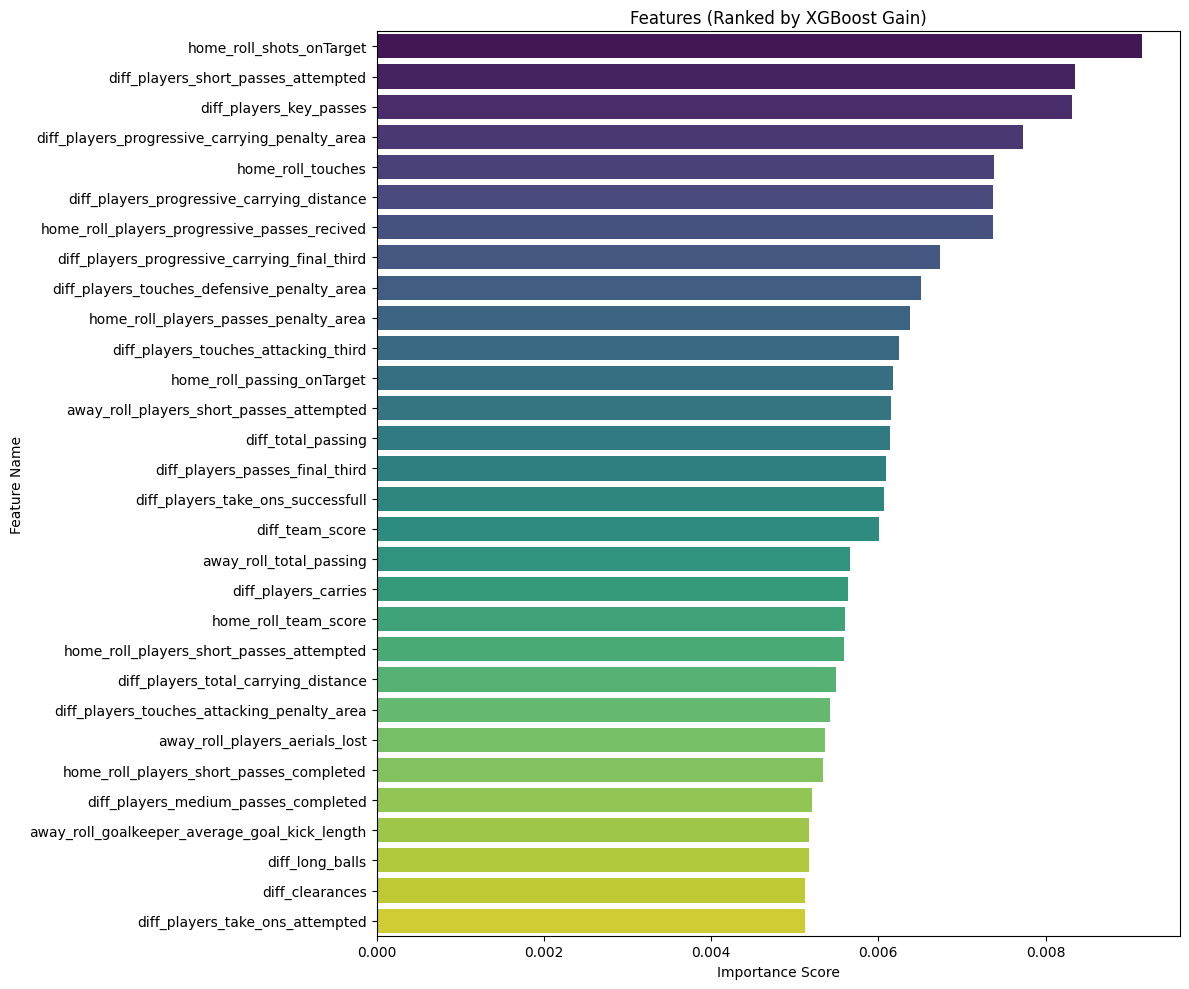

In [48]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

print("==================================================")
print("   🔍 FEATURE IMPORTANCE ANALYZER (ROBUST)        ")
print("==================================================")

# 1. Load the Model
try:
    artifacts = joblib.load('football_model_final.pkl')
    model = artifacts['model']
    features = artifacts['features']
    print("✅ Model Loaded.")
except FileNotFoundError:
    print("❌ Error: 'football_model_final.pkl' not found.")
    exit()

# 2. Extract Importances
try:
    # --- NAVIGATION LOGIC ---
    # 1. Get the first fitted CalibratedClassifier from the Cross-Validation list
    calibrated_layer = model.calibrated_classifiers_[0]
    
    # 2. Extract the underlying StackingClassifier
    # Handle Scikit-Learn version differences (estimator vs base_estimator)
    if hasattr(calibrated_layer, 'estimator'):
        stacking_clf = calibrated_layer.estimator
    else:
        stacking_clf = calibrated_layer.base_estimator
    
    # 3. Extract the XGBoost model
    # In your script, XGBoost was the first estimator: estimators=[('xgb', xgb_clf), ...]
    xgb_model = stacking_clf.estimators_[0]
    
    print(f"✅ Extracted Model: {type(xgb_model).__name__}")
    
    # 4. Get Scores
    importances = xgb_model.feature_importances_
    
    # Safety Check
    if len(importances) != len(features):
        print(f"⚠️ Mismatch! Model has {len(importances)} features, but list has {len(features)}.")
        print("Using indices instead of names...")
        feature_names = [f"Feature_{i}" for i in range(len(importances))]
    else:
        feature_names = features

    # Create DataFrame
    fi_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\n🏆 PREDICTIVE FEATURES:")
    print(fi_df.head(len(fi_df)).to_string(index=False))
    
    # 6. Check Player Stats
    print("\n🔎 NEW PLAYER STATS PERFORMANCE:")
    player_cols = [c for c in feature_names if 'player' in c or 'SCA' in c or 'xAG' in c]
    player_df = fi_df[fi_df['Feature'].isin(player_cols)]
    
    if not player_df.empty:
        print(player_df.to_string(index=False))
    else:
        print("No player stats found in the feature list.")

    # 7. Visualize
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=fi_df.head(30), palette='viridis')
    plt.title('Features (Ranked by XGBoost Gain)')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Error extracting features: {e}")
    # Debug info
    try:
        print(f"Object Type: {type(model)}")
        if hasattr(model, 'calibrated_classifiers_'):
            print(f"Calibrated Classifiers: {len(model.calibrated_classifiers_)}")
            print(f"Sub-Object dir: {dir(model.calibrated_classifiers_[0])}")
    except:
        pass